# Load/Pre-process Cleaned Dataset

Now that we have our cleaned dataset, we can load that and start building the model using PyTorch. Here we get rid of some unnecessary fields and then we also need to map the positions into integer numbers so that the neural network can deal with just the numbers.

Reasoning on discarding unnecessary fields:
* 'PPG' (Fantasy points per game) is derived from other fields and can be discarded.

* The Player's Name and Team will be kept for display, but when training the model we will discard this because we don't want the model trying to guess based on the name of the player. There are repeat names in this dataset. For example, this dataset will include RB Derek Henry in all 4 of his years. We don't want the model picking up on names like this and trying to use that to guess the players position.

In [10]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader

df = pd.read_csv('cleaned_data/combined.csv')

df = df.drop(['Player', 'Team', 'PPG'], axis=1)

# convert position = 'rb' to 0, position = 'wr' to 1
df['position'] = df['position'].map({'rb': 0, 'wr': 1})

# convert position into dtype float64
df['position'] = df['position'].astype('int64')


# Build the model class

In [11]:
import torch.nn as nn
import torch.nn.functional as F # allows data to move us forward in our function

# Create a Class that inherits nn.Module
class Model(nn.Module):
  # Input layer (13 features of the player) --> 
  # hidden layer1 with n neurons --> 
  # H2 (n) --> 
  # output layer (1 of 2 types of flower)
  def __init__(self, in_features=13, h1=24, h2=24, out_features=2):
    super().__init__() # instantiates the nn.Module
    self.fc1 = nn.Linear(in_features, h1)
    self.fc2 = nn.Linear(h1, h2)
    self.out = nn.Linear(h2, out_features)
  
  def forward(self, x):
    x = F.relu(self.fc1(x)) # rectified linear unit is going to make the output zero if it's <=, otherwise take the output
    x = F.relu(self.fc2(x))
    x = self.out(x)
    return x


# Pick a manual seed for randomization
torch.manual_seed(5)

# create an instance of the model
model = Model()

# Split dataset and set up optimizer

In [12]:
from sklearn.model_selection import train_test_split

# Train test and split
# set your x and y and convert to numpy arrays to make it easier
X = df.drop('position', axis=1).values # converts to numpy arrays
y = df['position'].values # converts to numpy arrays

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

X_train = torch.FloatTensor(X_train)
X_test = torch.FloatTensor(X_test)
y_train = torch.LongTensor(y_train) # because our classes here are whole numbers on the positions
y_test = torch.LongTensor(y_test)


# set the criterion of the model to measure the error
criterion = nn.CrossEntropyLoss() # takes the difference between the probabilities in a way
# -1 * sum((p(x)logp(x)))

# set the optimizer
# passing in the model that's the instance of our model class
# learning rate will be how granular your step is, the higher it is the less time it will 
# take to train the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


# Training Loop

Epoch 0 has loss 3.283392906188965
Epoch 10 has loss 0.18001659214496613
Epoch 20 has loss 0.1296917200088501
Epoch 30 has loss 0.08199802041053772
Epoch 40 has loss 0.06123443692922592
Epoch 50 has loss 0.04777242988348007
Epoch 60 has loss 0.03828435018658638
Epoch 70 has loss 0.03389906883239746
Epoch 80 has loss 0.02793513424694538
Epoch 90 has loss 0.020980585366487503


Text(0.5, 0, 'Epochs')

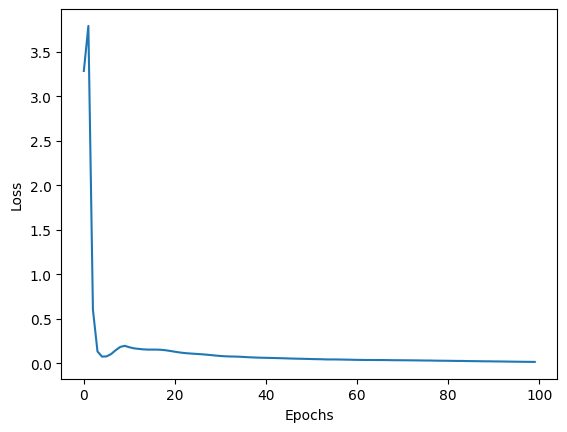

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

# Train our model
# Epochs (one run through all the training data in our network)
epochs = 100
losses = []

for i in range(epochs):
  # forward and predict
  y_pred = model.forward(X_train)

  # loss
  loss = criterion(y_pred, y_train)
  
  # keep track of losses
  losses.append(loss.item()) # this is a tensor so can use item to get the number

  # print every 10 epochs
  if i % 10 == 0:
    print(f"Epoch {i} has loss {loss}")

  # back propagation: adjust the model based on the error to fine tune the model
  optimizer.zero_grad() # resets the optimizer to allow it to learn from just the current batch
  loss.backward()
  optimizer.step() # will adjust the model accordingly because it was initialized with our model class


# Plot the loss
plt.plot(range(epochs), losses)
plt.ylabel('Loss')
plt.xlabel('Epochs')

# Testing the Model